<a href="https://colab.research.google.com/github/kustovass/detection-of-key-points-of-the-human-skeleton/blob/main/Graphs_yolov7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Построение графиков

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive


Mounted at /content/drive/
/content/drive/MyDrive


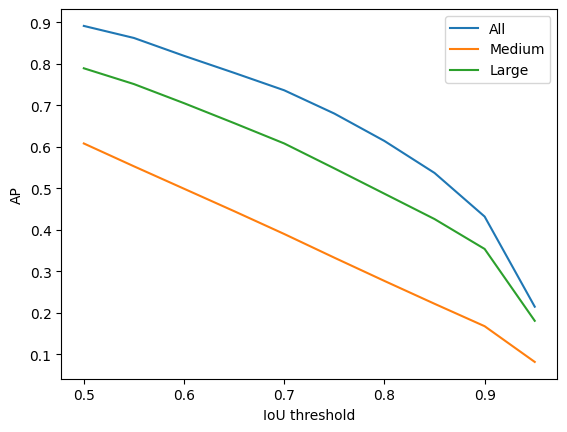

In [ ]:
import matplotlib.pyplot as plt

iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

AP_all = [0.891, 0.862, 0.819, 0.778, 0.736, 0.680, 0.614, 0.537, 0.432, 0.215]
AP_medium = [0.608, 0.553, 0.499, 0.445, 0.390, 0.333, 0.277, 0.222, 0.168, 0.082]
AP_large = [0.789, 0.751, 0.705, 0.657, 0.608, 0.548, 0.487, 0.426, 0.354, 0.181]

plt.plot(iou_thresholds, AP_all, label='All')
plt.plot(iou_thresholds, AP_medium, label='Medium')
plt.plot(iou_thresholds, AP_large, label='Large')
plt.xlabel('IoU threshold')
plt.ylabel('AP')
plt.legend()
plt.show()

# Кривая Precision-Recall

In [ ]:
import numpy as np
import json
import os

CONF = 0.001

def find_annotation(annotations, image_id):
  res = []
  for a in annotations:
    if a['image_id'] == image_id:
      res.append(a)
  return res

def is_right_keypoint(x_item, y_item, x_ann, y_ann):
  if ((x_item - x_ann)**2 + (y_item - y_ann)**2) ** 0.5 > CONF:
    return False
  return True

def right_keypoints(annotations_keypoints, item_keypoints):
  res_point = []
  res_score = []
  num = len(item_keypoints)
  for i in range(0, num, 3):
    if is_right_keypoint(item_keypoints[i], item_keypoints[i + 1], annotations_keypoints[i], annotations_keypoints[i + 1]):
      res_point.append(1)
    else:
      res_point.append(0)
    res_score.append(item_keypoints[i + 2])
  return res_point, res_score

with open('yolov7/runs/test/exp9/yolov7-w6-pose_predictions.json', 'r') as f:
    lst = json.load(f)


with open('coco/annotations/person_keypoints_val2017.json', 'r') as f:
    ann = json.load(f)

annotations = ann['annotations']

y_true = []
y_score = []

i = 0

for item in lst:
  image_id = item['image_id']
  score = item['score']
  keypoints = item['keypoints']
  temp_ann = find_annotation(annotations, image_id)
  if len(temp_ann) > 0:
    for a in temp_ann:
      r_k = right_keypoints(a['keypoints'], keypoints)
      y_true.extend(r_k[0])
      y_score.extend(r_k[1])
  else:
    print(image_id + ': no such image')

y_true = np.array(y_true)
y_score = np.array(y_score)

In [55]:
def k_exist(x, y, s):
  return False if s < 0.1 else True

TP = 0
FP = 0
FN = 0
precision = []
recall = []
for item in lst:
  image_id = item['image_id']
  score = item['score']
  keypoints = item['keypoints']
  temp_ann = find_annotation(annotations, image_id)
  for a in temp_ann:
    num = len(keypoints)
    for i in range(0, num, 3):
      key = a['keypoints']
      flag_item = k_exist(keypoints[i], keypoints[i + 1], keypoints[i + 2])
      flag_ann = k_exist(key[i], key[i + 1], key[i + 2])
      if not flag_item:
        FN += 1
      elif is_right_keypoint(keypoints[i], keypoints[i + 1], key[i], key[i + 1]):
        TP += 1
      else:
        FP += 1
  if TP != 0:
    precision.append(TP / (TP + FP))
    recall.append(TP / (TP + FN))
  TP = 0
  FP = 0
  FN = 0
print(precision)
print(recall)



[0.01282051282051282, 0.005917159763313609, 0.01282051282051282, 0.004201680672268907, 0.0058823529411764705, 0.007407407407407408, 0.013888888888888888, 0.004201680672268907, 0.029411764705882353, 0.004201680672268907, 0.004201680672268907, 0.004201680672268907, 0.029411764705882353, 0.004761904761904762, 0.005494505494505495, 0.0058823529411764705, 0.03333333333333333, 0.058823529411764705, 0.004761904761904762, 0.005494505494505495, 0.0196078431372549, 0.0196078431372549, 0.037037037037037035, 0.00510204081632653, 0.019230769230769232, 0.004464285714285714, 0.03125, 0.03125, 0.058823529411764705, 0.0196078431372549, 0.005208333333333333, 0.029411764705882353, 0.029411764705882353, 0.004201680672268907, 0.03333333333333333, 0.004201680672268907, 0.004201680672268907, 0.004201680672268907, 0.005681818181818182, 0.0053475935828877, 0.006060606060606061, 0.004201680672268907, 0.004464285714285714, 0.004901960784313725, 0.008928571428571428, 0.00980392156862745, 0.0053475935828877, 0.005

In [57]:
recall.sort()
precision = sorted(precision)
precision.reverse()

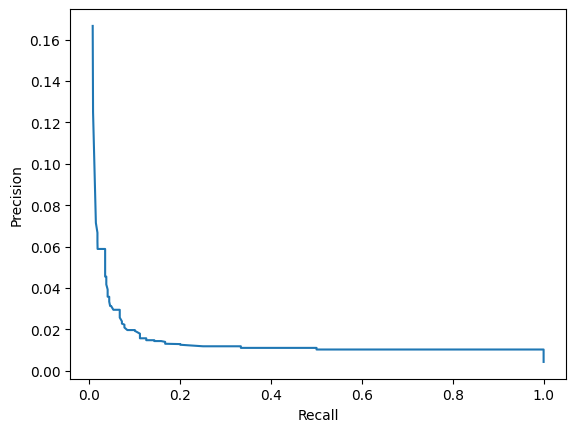

In [64]:
#from sklearn.metrics import precision_recall_curve
#import matplotlib.pyplot as plt

# Здесь необходимо получить значения вероятности и истинных меток для каждого класса объектов

#precision, recall, thresholds = precision_recall_curve(y_true, y_score)
#print(precision)
#print(recall)
#print(thresholds)


plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


# ROC кривая

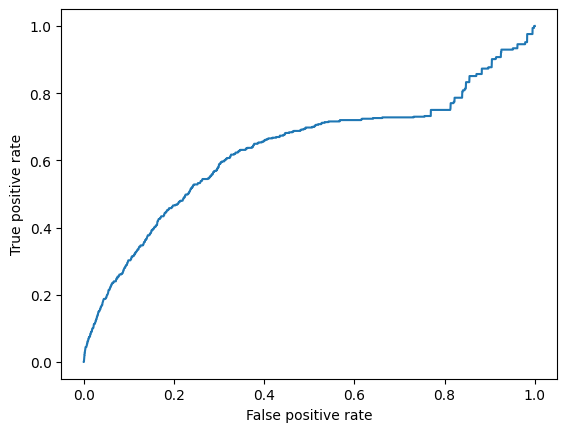

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Здесь также необходимо получить значения вероятности и истинных меток для каждого класса объектов

fpr, tpr, _ = roc_curve(y_true, y_score)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# AUC

In [ ]:
from sklearn.metrics import auc
auc_score = auc(fpr, tpr)
print("AUC: ", auc_score)

AUC:  0.6328148941518105
